*Estimated QPU usage: 73 minutes (tested on IBM Kyiv)*

## Background

[Variational quantum algorithms](https://arxiv.org/abs/2012.09265) are promising candidate hybrid-algorithms for observing quantum computation utility on noisy near-term devices. Variational algorithms are characterized by the use of a classical optimization algorithm to iteratively update a parameterized trial solution, or "ansatz". Chief among these methods is the Variational Quantum Eigensolver (VQE) that aims to solve for the ground state of a given Hamiltonian represented as a linear combination of Pauli terms, with an ansatz circuit where the number of parameters to optimize over is polynomial in the number of qubits.  Given that the size of the full solution vector is exponential in the number of qubits, successful minimization using VQE requires, in general, additional problem-specific information to define the structure of the ansatz circuit.

Executing a VQE algorithm requires the following components:

1. Hamiltonian and ansatz (problem specification)
2. Qiskit Runtime estimator
3. Classical optimizer

Although the Hamiltonian and ansatz require domain-specific knowledge to construct, these details are immaterial to the Runtime, and we can execute a wide class of VQE problems in the same manner.


## Requirements

Before starting this tutorial, ensure that you have the following installed:

* Qiskit SDK 1.0 or later, with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime 0.22 or later(`pip install qiskit-ibm-runtime`)


## Step 1. Map classical inputs to a quantum problem

Although the problem instance in question for the VQE algorithm can come from a variety of domains, the form for execution through Qiskit Runtime is the same. Qiskit provides a convenience class for expressing Hamiltonians in Pauli form, and a collection of widely used ansatz circuits in the [`qiskit.circuit.library`](https://docs.quantum-computing.ibm.com/api/qiskit/circuit_library).

This example Hamiltonian is derived from a quantum chemistry problem.


### Setup

Here we import the tools needed for a VQE experiment.


In [146]:
# General imports
import numpy as np
np.random.seed(42)

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import n_local

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [147]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeTorontoV2, FakeVigoV2
from qiskit.transpiler import CouplingMap
from qiskit_aer import noise

# Build noise model from backend properties
backend = FakeTorontoV2()
noise_model = NoiseModel.from_backend(backend)
noise_model = noise.NoiseModel()

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map
coupling_map = CouplingMap(coupling_map)

# Error probabilities
prob_1 = 0.0001  # 1-qubit gate
prob_2 = 0.0001  # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['rz', 'sx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

In [148]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeTorontoV2
from qiskit_aer.noise import NoiseModel
from qiskit import transpile
from qiskit_aer import QasmSimulator

# To run on hardware, select the backend with the fewest number of jobs in the queue
noisy = True

if noisy:
    #noise_model = NoiseModel.from_backend(FakeTorontoV2())
    #backend = QasmSimulator.from_backend(method='density_matrix', noise_model=noise_model, configuration=FakeTorontoV2().configuration())
    #backend = AerSimulator.from_backend(FakeTorontoV2())
    backend = AerSimulator(noise_model=noise_model, basis_gates=basis_gates, coupling_map=coupling_map)
else:
    backend = AerSimulator()

noise_free_backend = AerSimulator()

import matplotlib.pyplot as plt
from qiskit_algorithms import NumPyEigensolver

In [149]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

In [150]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

from qiskit_nature.second_q.mappers import JordanWignerMapper


mapper = JordanWignerMapper()

h2_molecule = "H .0 .0 .0; H .0 .0 0.735"  # H-H bond length ~0.735 Å
lih_molecule = "Li 0.0 0.0 0.0; H 0.0 0.0 1.570"  # Li-H bond length ~1.6 Å
beh2_molecule = "Be 0.0 0.0 0.0; H 0.0 0.0 3.00; H 0.0 0.0 3.00"  # Be-H bond length ~1.3 Å

driver = PySCFDriver(
    atom=h2_molecule,
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

hamiltonian = mapper.map(es_problem.hamiltonian.second_q_op())
print(hamiltonian)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'ZIII', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.81054798+0.j,  0.17218393+0.j, -0.22575349+0.j,  0.12091263+0.j,
  0.17218393+0.j,  0.16892754+0.j, -0.22575349+0.j,  0.16614543+0.j,
  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,
  0.16614543+0.j,  0.17464343+0.j,  0.12091263+0.j])


In [151]:
hamiltonian = SparsePauliOp.from_list([
    ("ZIII", -0.5),   # Bias on qubit 0
    ("IZII",  0.8),   # Bias on qubit 1
    ("IIZI", -0.6),   # Bias on qubit 2
    ("IIIZ",  0.3),   # Bias on qubit 3
    ("ZZII", -0.4),   # Interaction between qubits 0 and 1
    ("IIZZ",  0.5),   # Interaction between qubits 2 and 3
    ("ZIZI", -0.2),   # Interaction between qubits 0 and 2
    ("ZZZZ",  0.7),   # Global interaction term
])

Our choice of ansatz is the `EfficientSU2` that, by default, linearly entangles qubits, making it ideal for quantum hardware with limited connectivity.


In [152]:
n_qubits = hamiltonian.num_qubits
n_layers =  5
entanglement = "full"

multi_qubit_gates = ["cx"]
single_qubit_gates = ["sx", "ry"]
circ_name = f"twolocal_{n_qubits}qubits_{n_layers}layers_{entanglement}_entanglement"
print(circ_name)

# Create circuit
ansatz = n_local(
    num_qubits=n_qubits,
    rotation_blocks=single_qubit_gates,
    entanglement_blocks=multi_qubit_gates,
    entanglement=entanglement,
    reps=n_layers,
    parameter_prefix="θ",
    insert_barriers=False,
    overwrite_block_parameters=True,
    skip_final_rotation_layer=False,
    skip_unentangled_qubits=False,
    name=circ_name,
)

if False:
    ansatz = UCCSD(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
        ),
    )

#ansatz.draw(style="iqp") 

twolocal_4qubits_5layers_full_entanglement


From the previous figure we see that our ansatz circuit is defined by a vector of parameters, $\theta_{i}$, with the total number given by:


In [153]:
num_params = ansatz.num_parameters
num_params

24

## Step 2. Optimize problem for quantum execution


To reduce the total job execution time, Qiskit primitives only accept circuits (ansatz) and observables (Hamiltonian) that conform to the instructions and connectivity supported by the target QPU (referred to as instruction set architecture (ISA) circuits and observables).


### ISA circuit


Schedule a series of [`qiskit.transpiler`](https://docs.quantum-computing.ibm.com/api/qiskit/transpiler) passes to optimize the circuit for a selected backend and make it compatible with the backend's ISA. This can be easily done with a preset pass manager from `qiskit.transpiler` and its `optimization_level` parameter.

The lowest optimization level does the minimum needed to get the circuit running on the device; it maps the circuit qubits to the device qubits and adds swap gates to allow all two-qubit operations. The highest optimization level is much smarter and uses lots of tricks to reduce the overall gate count. Since multi-qubit gates have high error rates and qubits decohere over time, the shorter circuits should give better results.


In [154]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(
    #target=target,
    basis_gates=backend.configuration().basis_gates,
    coupling_map=backend.configuration().coupling_map,
    optimization_level=3
)

ansatz_isa = pm.run(ansatz)

### ISA observable


Transform the Hamiltonian to make it backend-compatible before running jobs with [`Runtime Estimator V2`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2#run). Perform the transformation by using the `apply_layout` method of `SparsePauliOp` object.


In [155]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

## Step 3. Execute using Qiskit Primitives

Like many classical optimization problems, the solution to a VQE problem can be formulated as minimization of a scalar cost function.  By definition, VQE looks to find the ground state solution to a Hamiltonian by optimizing the ansatz circuit parameters to minimize the expectation value (energy) of the Hamiltonian.  With the Qiskit Runtime [`Estimator`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2) directly taking a Hamiltonian and parameterized ansatz, and returning the necessary energy, the cost function for a VQE instance is quite simple.

Note that the `run()` method of [Qiskit Runtime `EstimatorV2`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2)  takes an iterable of `primitive unified blocs (PUBs)`. Each PUB is an iterable in the format `(circuit, observables, parameter_values: Optional, precision: Optional)`.


In [156]:
def calc_probs(qc, shots):
    qc.measure_active()
    result = backend.run(qc, shots=shots).result()
    counts = result.get_counts()
    return np.array(list(counts.values())) / shots

In [157]:
import numpy as np

from qiskit.primitives.utils import _statevector_from_circuit

def compute_entropy(probabilities):
    """Compute entropy from measurement results."""
    probabilities = probabilities[probabilities > 0]  # Avoid log(0)
    return -np.sum(probabilities * np.log(probabilities))

def compute_normalized_entropy(probabilities, states=2):
    """Compute entropy from measurement results."""
    probabilities = probabilities[probabilities > 0]  # Avoid log(0)
    return -np.sum(probabilities * np.log(probabilities)) / np.log(states)

def cost_func(params, isa_ansatz, hamiltonian, estimator, N0=1000, strategy="dynamic", history_dict=None, rng=None):
    """Return estimate of energy with adaptive shot allocation based on entropy.

    Parameters:
        params (ndarray): Array of ansatz parameters
        isa_ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        history_dict (dict): Dictionary for storing intermediate results
        N0 (int, optional): Base shot count multiplier for entropy scaling

    Returns:
        float: Energy estimate
    """
    if strategy == "dynamic":
        prev_entropy = history_dict["entropy_history"][-1]
        shots = int(64 * 2 ** prev_entropy)
    elif strategy == "linear":
        shots = max(64, N0 - 10 * history_dict["iters"])
    elif strategy == "step":
        step = 10 * np.floor(history_dict["iters"] / 10)
        shots = max(64, N0 - 10 * step)
    elif strategy == "proposed":
        prev_entropy = history_dict["entropy_history"][-1]
        #shots = int(N0 * prev_entropy)
        shots = int(N0 * prev_entropy + N0 / 2 * (1 - prev_entropy))
    elif strategy == "constant":
        shots = N0 #10000 # 10k

    estimator.options.default_shots = shots

    # Run estimation
    pub = (isa_ansatz, [hamiltonian], [params])
    job = estimator.run([pub])
    result = job.result()
    
    # Hack to get the full result distribution
    # NOTE: using the un-compiled ansatz
    circ = isa_ansatz.assign_parameters(params)
    #final_state = _statevector_from_circuit(circ, rng)
    probs = calc_probs(circ, shots)

    # Compute new entropy
    if strategy == "proposed":
        entropy = compute_normalized_entropy(probs, states=(2 ** isa_ansatz.num_qubits))
    else:
        entropy = compute_entropy(probs)

    # Extract energy estimate
    energy = result[0].data.evs[0]

    # Update cost history
    history_dict["iters"] += 1
    history_dict["prev_vector"] = params
    history_dict["cost_history"].append(energy)
    history_dict["entropy_history"].append(entropy)
    history_dict["shots_history"].append(shots)

    print(f"Iters. done: {history_dict['iters']} [Current cost: {energy}] [Shots: {shots}] [Entropy: {entropy}]")

    return energy

Note that, in addition to the array of optimization parameters that must be the first argument, we use additional arguments to pass the terms needed in the cost function, such as the `cost_history_dict`. This dictionary stores the current vector at each iteration, for example in case you need to restart the routine due to failure, and also returns the current iteration number and average time per iteration.


We can now use a classical optimizer of our choice to minimize the cost function. Here, we use the [COBYLA routine from SciPy through the `minimize` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). Note that when running on real quantum hardware, the choice of optimizer is important, as not all optimizers handle noisy cost function landscapes equally well.

To begin the routine, specify a random initial set of parameters:


In [158]:
np.random.seed(50)
x0 = 2 * np.pi * np.random.random(num_params)

In [159]:
x0

array([3.10767379, 1.43308841, 1.60519   , 2.49021427, 2.37074068,
       6.26166056, 2.56477865, 4.84995301, 4.77859294, 1.94784618,
       2.1773826 , 2.21020353, 0.91399522, 6.11143246, 5.7125366 ,
       3.51831425, 1.97034877, 5.58072543, 4.23846758, 2.4572749 ,
       3.18673184, 3.29303943, 5.83080179, 3.59004287])

Because we are sending a large number of jobs that we would like to execute together, we use a [`Session`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Session) to execute all the generated circuits in one block.  Here `args` is the standard SciPy way to supply the additional parameters needed by the cost function.


In [163]:
experiment_history = {}
strategies = ["constant", "dynamic", "proposed"]
for strategy in strategies:
    experiment_history[strategy] = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
        "entropy_history": [1],
        "shots_history": [],
    }

for strategy in strategies:
    np.random.seed(42)
    rng = np.random.default_rng(seed=42)

    with Session(backend=backend) as session:
        estimator = Estimator(mode=session)#, options={"seed_estimator":123})

        print(f"Running optimization with {strategy} shot allocation")
        res = minimize(cost_func, x0,
            args=(ansatz_isa, hamiltonian_isa, estimator, 640, strategy, experiment_history[strategy], rng),
            bounds=[(0, 2 * np.pi)] * num_params, tol=1e-2,
            method="COBYLA", options={'seed':42}
        )

Running optimization with constant shot allocation
Iters. done: 1 [Current cost: 0.3087499999999999] [Shots: 640] [Entropy: 2.2705338792022487]
Iters. done: 2 [Current cost: 0.21031249999999996] [Shots: 640] [Entropy: 2.387662627281792]
Iters. done: 3 [Current cost: 0.2721875] [Shots: 640] [Entropy: 2.3320524073593645]
Iters. done: 4 [Current cost: 0.3578125] [Shots: 640] [Entropy: 2.3646074307261022]
Iters. done: 5 [Current cost: 0.4362500000000002] [Shots: 640] [Entropy: 2.326763626260207]
Iters. done: 6 [Current cost: 0.7421875] [Shots: 640] [Entropy: 2.3247946037614047]
Iters. done: 7 [Current cost: 0.5703125] [Shots: 640] [Entropy: 2.384113293040675]
Iters. done: 8 [Current cost: -0.40468750000000003] [Shots: 640] [Entropy: 2.3712539093915472]
Iters. done: 9 [Current cost: -0.009062500000000029] [Shots: 640] [Entropy: 2.472219772289653]
Iters. done: 10 [Current cost: -0.07218750000000004] [Shots: 640] [Entropy: 2.3126826388562316]
Iters. done: 11 [Current cost: -0.5609375000000001

/Users/patrickhopf/Code/mqt/mqt-bench/.venv/lib/python3.12/site-packages/scipy/optimize/_minimize.py:737: OptimizeWarning: Unknown solver options: seed
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Iters. done: 17 [Current cost: -0.27093749999999994] [Shots: 640] [Entropy: 2.377507734131779]
Iters. done: 18 [Current cost: -0.6368750000000001] [Shots: 640] [Entropy: 2.136745862941825]
Iters. done: 19 [Current cost: 0.18843749999999995] [Shots: 640] [Entropy: 2.4969054161195396]
Iters. done: 20 [Current cost: -0.6200000000000001] [Shots: 640] [Entropy: 2.197474501057145]
Iters. done: 21 [Current cost: -0.385] [Shots: 640] [Entropy: 2.1627120747143405]
Iters. done: 22 [Current cost: -0.55125] [Shots: 640] [Entropy: 1.9613589528927096]
Iters. done: 23 [Current cost: -0.72875] [Shots: 640] [Entropy: 2.140014211386424]
Iters. done: 24 [Current cost: -0.022812499999999986] [Shots: 640] [Entropy: 2.2785235927499157]
Iters. done: 25 [Current cost: -0.17875000000000002] [Shots: 640] [Entropy: 1.996569362738544]
Iters. done: 26 [Current cost: -0.9146875000000001] [Shots: 640] [Entropy: 1.713426170757917]
Iters. done: 27 [Current cost: -0.8718750000000002] [Shots: 640] [Entropy: 1.8099279397

/Users/patrickhopf/Code/mqt/mqt-bench/.venv/lib/python3.12/site-packages/scipy/optimize/_minimize.py:737: OptimizeWarning: Unknown solver options: seed
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Iters. done: 5 [Current cost: 0.10938511326860836] [Shots: 309] [Entropy: 2.2793370269279496]
Iters. done: 6 [Current cost: 0.7086816720257235] [Shots: 310] [Entropy: 2.4542372479900885]
Iters. done: 7 [Current cost: 0.5566951566951568] [Shots: 350] [Entropy: 2.3616289399262347]
Iters. done: 8 [Current cost: -0.47234042553191485] [Shots: 328] [Entropy: 2.4515006050653403]
Iters. done: 9 [Current cost: -0.017094017094017117] [Shots: 350] [Entropy: 2.4510272713842163]
Iters. done: 10 [Current cost: -0.15644699140401147] [Shots: 349] [Entropy: 2.345202818650092]
Iters. done: 11 [Current cost: -0.5323076923076923] [Shots: 325] [Entropy: 2.1508756737071675]
Iters. done: 12 [Current cost: 0.0996491228070175] [Shots: 284] [Entropy: 2.5025948434876786]
Iters. done: 13 [Current cost: -0.4475138121546962] [Shots: 362] [Entropy: 2.3846691096249106]
Iters. done: 14 [Current cost: -0.4650746268656716] [Shots: 334] [Entropy: 2.272144369884436]
Iters. done: 15 [Current cost: -0.4097087378640777] [Sho

/Users/patrickhopf/Code/mqt/mqt-bench/.venv/lib/python3.12/site-packages/scipy/optimize/_minimize.py:737: OptimizeWarning: Unknown solver options: seed
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Iters. done: 7 [Current cost: 0.3938888888888889] [Shots: 360] [Entropy: 0.12471563250381672]
Iters. done: 8 [Current cost: -0.43175487465181056] [Shots: 359] [Entropy: 0.12576904211863169]
Iters. done: 9 [Current cost: -0.030555555555555558] [Shots: 360] [Entropy: 0.1305784246470015]
Iters. done: 10 [Current cost: -0.08729281767955804] [Shots: 361] [Entropy: 0.12617827533413128]
Iters. done: 11 [Current cost: -0.5122222222222224] [Shots: 360] [Entropy: 0.12378511795457561]
Iters. done: 12 [Current cost: 0.06573816155988857] [Shots: 359] [Entropy: 0.1374505009244933]
Iters. done: 13 [Current cost: -0.40440771349862265] [Shots: 363] [Entropy: 0.12764872790884627]
Iters. done: 14 [Current cost: -0.4422222222222223] [Shots: 360] [Entropy: 0.12577194645382395]
Iters. done: 15 [Current cost: -0.3038888888888888] [Shots: 360] [Entropy: 0.13020608937164688]
Iters. done: 16 [Current cost: -0.243646408839779] [Shots: 361] [Entropy: 0.135399849407002]
Iters. done: 17 [Current cost: -0.3090909090

At the terminus of this routine we have a result in the standard SciPy `OptimizeResult` format.  From this we see that it took `nfev` number of cost function evaluations to obtain the solution vector of parameter angles (`x`) that, when plugged into the ansatz circuit, yield the approximate ground state solution we were looking for.


In [164]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.422543352601156
       x: [ 2.904e+00  1.646e+00 ...  5.200e+00  3.150e+00]
    nfev: 136
   maxcv: 0.0

## Step 4. Post-process, return result in classical format


If the procedure terminates correctly, then the `prev_vector` and `iters` values in our `cost_history_dict` dictionary should be equal to the solution vector and total number of function evaluations, respectively.


We can also now view the progress toward convergence as monitored by the cost history at each iteration:


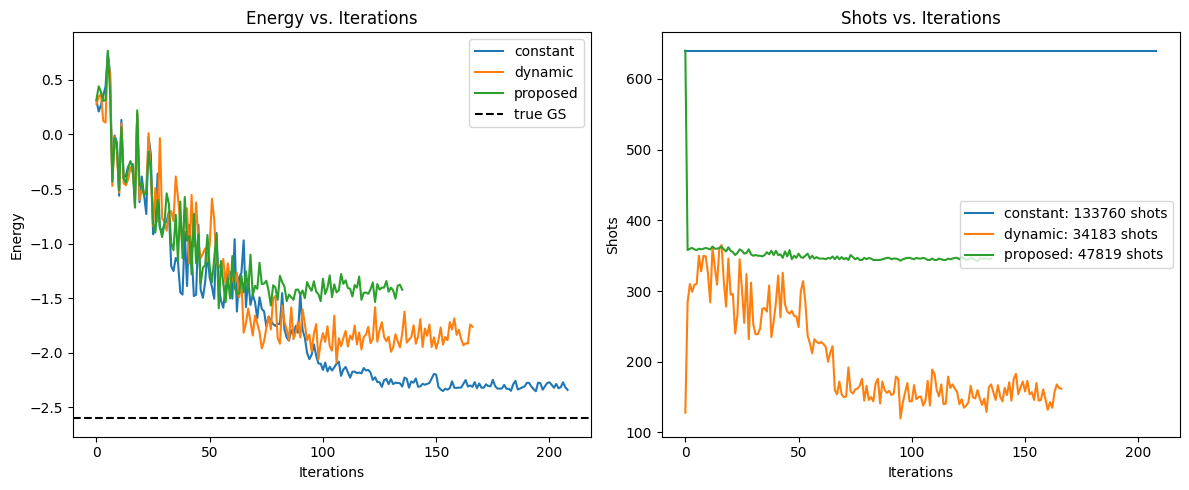

In [165]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# First subplot: Cost vs. Iterations
ax1 = axes[0]
for strategy in strategies:
    ax1.plot(range(experiment_history[strategy]["iters"]), 
             experiment_history[strategy]["cost_history"], label=strategy)


solver = NumPyEigensolver(k=1)  # Get lowest eigenvalue
groundtruth = solver.compute_eigenvalues(hamiltonian)
max_it = max(experiment_history[strategy]["iters"] for strategy in strategies)
ax1.axhline(groundtruth.eigenvalues[0].real, 0, max_it, label="true GS", linestyle="--", color="black")

ax1.set_xlabel("Iterations")
ax1.set_ylabel("Energy")
ax1.set_title("Energy vs. Iterations")
ax1.legend()

# Second subplot: Shots vs. Iterations
ax2 = axes[1]
for strategy in strategies:
    ax2.plot(range(experiment_history[strategy]["iters"]), 
             experiment_history[strategy]["shots_history"], 
             label=f"{strategy}: {sum(experiment_history[strategy]['shots_history'])} shots")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Shots")
ax2.set_title("Shots vs. Iterations")
ax2.legend()

plt.tight_layout()
plt.show()

## Tutorial Survey

<table style="width: 100%;">
<tbody>
<tr>
<td style="width: 10%;"><img src="https://learning-api.quantum.ibm.com/assets/53171443-b07b-4ae6-a4be-9aec32a854f5" alt="Survey" width="100%" height="100%"></td>
<td style="width: 80%;"><strong><a title="Tutorial Survey" href="https://your.feedback.ibm.com/jfe/form/SV_9AizRyKFHEGzVs2" target="_blank">Tutorial Survey</a></strong><br>Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.</td>
</tr>
</tbody>
</table>
